# **특허+논문 수 조화평균**

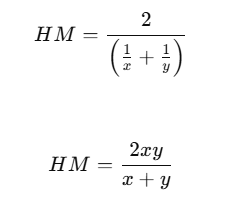

**Why use harmonic mean in your case?**
- You have two publication measures:
    - journal publications (scientific output)
    - patent publications (technological output)
- These two can be on very different scales (ex: 10,000 journal papers vs. 50 patents in one region).
- The harmonic mean prevents one very large number from dominating the average.
- It reflects balance: the harmonic mean is low if either value is low.
- In your case, this gives a kind of "balanced productivity score" per region.

- In simple terms: both knowledge creation (papers) and application (patents) need to be strong to get a high harmonic mean.

**Harmonic mean is undefined if any value is zero**
- You need to handle zeros: either replace with a small positive number, or exclude those regions.

# **특허 수**

In [63]:
import pandas as pd 
patent_app = pd.read_csv('patent_app.csv')
patent_app

,appln_id,appln_kind,appln_filing_year,docdb_family_id,docdb_family_size
0,1,A,2000,8554171,6
1,2,A,1992,27517085,8
2,7,A,2000,10861834,7
3,9,A,2000,8555798,23
4,10,A,2001,7655749,9
...,...,...,...,...,...
8290059,606446150,U,2020,78048989,2
8290060,606446152,U,2022,89853283,1
8290061,606471480,A,2022,89854709,1
8290062,606471485,A,2022,89854710,1


In [64]:
patent_pers_1 = pd.read_csv('patent_pers_1.csv')
patent_pers_2 = pd.read_csv('patent_pers_2.csv')
patent_pers_3 = pd.read_csv('patent_pers_3.csv')

patent_pers = pd.concat([patent_pers_1, patent_pers_2, patent_pers_3], ignore_index=True)
patent_pers = patent_pers[['appln_id', 'nuts', 'nuts_level']]  # correct column selection
patent_pers = patent_pers.drop_duplicates()

# drop rows where nuts_level is 0 
patent_pers = patent_pers[patent_pers['nuts_level'] != 0]

# drop rows where 'nuts' is NaN
patent_pers = patent_pers.dropna(subset=['nuts'])

# remove rows where nuts_level is 1 or 2 
patent_pers = patent_pers[~patent_pers['nuts_level'].isin([1, 2])]

patent_pers = patent_pers[patent_pers['nuts'] != 'AN000']

# slice nuts to 4 digits
patent_pers['nuts'] = patent_pers['nuts'].str.slice(0, 4)

# change nuts to eu_nuts_id 
patent_pers.rename(columns={'nuts': 'eu_nuts_id'}, inplace=True)

# drop nuts_level column
patent_pers = patent_pers.drop(columns=['nuts_level'])
patent_pers

,appln_id,eu_nuts_id
0,1,FI1B
1,1,FI19
5,2,UKI3
6,2,UKH1
13,7,FI1B
...,...,...
27942476,604927030,SE23
27943200,605163630,UKJ2
27943526,605222772,DE21
27948230,606280441,CH03


In [65]:
patent_app = pd.merge(patent_app, patent_pers, on='appln_id', how='left')
patent_app.head()

,appln_id,appln_kind,appln_filing_year,docdb_family_id,docdb_family_size,eu_nuts_id
0,1,A,2000,8554171,6,FI1B
1,1,A,2000,8554171,6,FI19
2,2,A,1992,27517085,8,UKI3
3,2,A,1992,27517085,8,UKH1
4,7,A,2000,10861834,7,FI1B


In [66]:
# create 'period' column 
def assign_period(pubyear):
    if 1981 <= pubyear <= 1985:
        return 1
    elif 1986 <= pubyear <= 1990:
        return 2 
    elif 1991 <= pubyear <= 1995:
        return 3 
    elif 1996 <= pubyear <= 2000:
        return 4
    elif 2001 <= pubyear <= 2005:
        return 5
    elif 2006 <= pubyear <= 2010:
        return 6
    elif 2011 <= pubyear <= 2015:
        return 7
    elif 2016 <= pubyear <= 2020:
        return 8
    else:
        return 0 

patent_app['period'] = patent_app['appln_filing_year'].apply(assign_period)
patent_app

,appln_id,appln_kind,appln_filing_year,docdb_family_id,docdb_family_size,eu_nuts_id,period
0,1,A,2000,8554171,6,FI1B,4
1,1,A,2000,8554171,6,FI19,4
2,2,A,1992,27517085,8,UKI3,3
3,2,A,1992,27517085,8,UKH1,3
4,7,A,2000,10861834,7,FI1B,4
...,...,...,...,...,...,...,...
9575303,606446150,U,2020,78048989,2,NaN,8
9575304,606446152,U,2022,89853283,1,NaN,0
9575305,606471480,A,2022,89854709,1,NaN,0
9575306,606471485,A,2022,89854710,1,NaN,0


In [67]:
# group by eu_nuts_id and period, and count the number of unique appln_id 
num_patents = patent_app.groupby(['eu_nuts_id', 'period'])['appln_id'].nunique().reset_index()
num_patents.rename(columns={'appln_id': 'num_patents'}, inplace=True)
num_patents

,eu_nuts_id,period,num_patents
0,AT11,0,9
1,AT11,1,30
2,AT11,2,24
3,AT11,3,39
4,AT11,4,68
...,...,...,...
2664,UKN0,4,118
2665,UKN0,5,155
2666,UKN0,6,236
2667,UKN0,7,385


In [68]:
# group by eu_nuts_id and period, and count the number of docdb_family_id
num_families = patent_app.groupby(['eu_nuts_id', 'period'])['docdb_family_id'].nunique().reset_index()
num_families.rename(columns={'docdb_family_id': 'num_families'}, inplace=True)
num_families

,eu_nuts_id,period,num_families
0,AT11,0,9
1,AT11,1,29
2,AT11,2,24
3,AT11,3,39
4,AT11,4,67
...,...,...,...
2664,UKN0,4,114
2665,UKN0,5,149
2666,UKN0,6,222
2667,UKN0,7,368


In [69]:
num_patents = pd.merge(num_patents, num_families, on=['eu_nuts_id', 'period'], how='left')
num_patents

,eu_nuts_id,period,num_patents,num_families
0,AT11,0,9,9
1,AT11,1,30,29
2,AT11,2,24,24
3,AT11,3,39,39
4,AT11,4,68,67
...,...,...,...,...
2664,UKN0,4,118,114
2665,UKN0,5,155,149
2666,UKN0,6,236,222
2667,UKN0,7,385,368


# **논문 수**

In [70]:
pub_institution = pd.read_csv('eu_pub_prox_institution.csv')
pub_institution

C:\Users\user\AppData\Local\Temp\ipykernel_19892\3195423231.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  pub_institution = pd.read_csv('eu_pub_prox_institution.csv')


,pubid,pubyear,institution_id_te,organization,country,eu_nuts_id
0,2.0,1992,81734973.0,UNIV YORK,ENGLAND,UKE21
1,2.0,1992,81889854.0,UNIVERSITY OF YORK - UK,ENGLAND,UKE21
2,3.0,1992,82583283.0,UNIVERSITY OF BIELEFELD,GERMANY,DEA41
3,3.0,1992,68681333.0,UNIV BIELEFELD,GERMANY,DEA41
4,4.0,1992,76491407.0,UNIV NOTTINGHAM,ENGLAND,UKF14
...,...,...,...,...,...,...
24924152,55560571.0,1992,NaN,NaN,NaN,NaN
24924153,55560572.0,1992,NaN,NaN,NaN,NaN
24924154,55560609.0,1992,NaN,NaN,NaN,NaN
24924155,55560611.0,1992,NaN,NaN,NaN,NaN


In [71]:
# create 'period' column 
def assign_period(pubyear):
    if 1981 <= pubyear <= 1985:
        return 1
    elif 1986 <= pubyear <= 1990:
        return 2 
    elif 1991 <= pubyear <= 1995:
        return 3 
    elif 1996 <= pubyear <= 2000:
        return 4
    elif 2001 <= pubyear <= 2005:
        return 5
    elif 2006 <= pubyear <= 2010:
        return 6
    elif 2011 <= pubyear <= 2015:
        return 7
    elif 2016 <= pubyear <= 2020:
        return 8
    else:
        return 0 
    
pub_institution['period'] = pub_institution['pubyear'].apply(assign_period)
pub_institution.head()

,pubid,pubyear,institution_id_te,organization,country,eu_nuts_id,period
0,2.0,1992,81734973.0,UNIV YORK,ENGLAND,UKE21,3
1,2.0,1992,81889854.0,UNIVERSITY OF YORK - UK,ENGLAND,UKE21,3
2,3.0,1992,82583283.0,UNIVERSITY OF BIELEFELD,GERMANY,DEA41,3
3,3.0,1992,68681333.0,UNIV BIELEFELD,GERMANY,DEA41,3
4,4.0,1992,76491407.0,UNIV NOTTINGHAM,ENGLAND,UKF14,3


In [72]:
# slice eu_nuts_id to 4 digits
pub_institution['eu_nuts_id'] = pub_institution['eu_nuts_id'].str.slice(0, 4)
pub_institution.head()

,pubid,pubyear,institution_id_te,organization,country,eu_nuts_id,period
0,2.0,1992,81734973.0,UNIV YORK,ENGLAND,UKE2,3
1,2.0,1992,81889854.0,UNIVERSITY OF YORK - UK,ENGLAND,UKE2,3
2,3.0,1992,82583283.0,UNIVERSITY OF BIELEFELD,GERMANY,DEA4,3
3,3.0,1992,68681333.0,UNIV BIELEFELD,GERMANY,DEA4,3
4,4.0,1992,76491407.0,UNIV NOTTINGHAM,ENGLAND,UKF1,3


In [73]:
# group by eu_nuts_id and period, and count the number of unique pub_id
num_papers = pub_institution.groupby(['eu_nuts_id', 'period'])['pubid'].nunique().reset_index()
num_papers.rename(columns={'pubid': 'num_papers'}, inplace=True)
num_papers.head()

,eu_nuts_id,period,num_papers
0,AT11,4,34
1,AT11,5,64
2,AT11,6,2
3,AT11,7,4
4,AT12,2,2


In [74]:
num_publication = pd.merge(num_patents, num_papers, on=['eu_nuts_id', 'period'], how='outer')
num_publication = num_publication.fillna(0)
num_publication

,eu_nuts_id,period,num_patents,num_families,num_papers
0,AT11,0,9.0,9.0,0.0
1,AT11,1,30.0,29.0,0.0
2,AT11,2,24.0,24.0,0.0
3,AT11,3,39.0,39.0,0.0
4,AT11,4,68.0,67.0,34.0
...,...,...,...,...,...
2726,UKN0,4,118.0,114.0,3851.0
2727,UKN0,5,155.0,149.0,6627.0
2728,UKN0,6,236.0,222.0,575.0
2729,UKN0,7,385.0,368.0,110.0


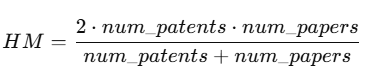

In [75]:
import numpy as np

# Replace zeros with np.nan to avoid division by zero (optional, depending on your data)
num_publication['num_patents'] = num_publication['num_patents'].replace(0, np.nan)
num_publication['num_families'] = num_publication['num_families'].replace(0, np.nan)
num_publication['num_papers'] = num_publication['num_papers'].replace(0, np.nan)

# Calculate harmonic mean per row
num_publication['harmonic_mean'] = 2 * num_publication['num_patents'] * num_publication['num_papers'] / (num_publication['num_patents'] + num_publication['num_papers'])

num_publication['harmonic_mean_with_families'] = 2 * num_publication['num_families'] * num_publication['num_papers'] / (num_publication['num_families'] + num_publication['num_papers'])

num_publication

,eu_nuts_id,period,num_patents,num_families,num_papers,harmonic_mean,harmonic_mean_with_families
0,AT11,0,9.0,9.0,NaN,NaN,NaN
1,AT11,1,30.0,29.0,NaN,NaN,NaN
2,AT11,2,24.0,24.0,NaN,NaN,NaN
3,AT11,3,39.0,39.0,NaN,NaN,NaN
4,AT11,4,68.0,67.0,34.0,45.333333,45.108911
...,...,...,...,...,...,...,...
2726,UKN0,4,118.0,114.0,3851.0,228.983623,221.444641
2727,UKN0,5,155.0,149.0,6627.0,302.915069,291.447166
2728,UKN0,6,236.0,222.0,575.0,334.648582,320.326223
2729,UKN0,7,385.0,368.0,110.0,171.111111,169.372385


# **특허 인용 수**

In [5]:
import pandas as pd 
patent_app = pd.read_csv('patent_app.csv')
patent_app = patent_app[['appln_id', 'appln_filing_year']]
patent_app

,appln_id,appln_filing_year
0,1,2000
1,2,1992
2,7,2000
3,9,2000
4,10,2001
...,...,...
8290059,606446150,2020
8290060,606446152,2022
8290061,606471480,2022
8290062,606471485,2022


In [6]:
patent_pers_1 = pd.read_csv('patent_pers_1.csv')
patent_pers_2 = pd.read_csv('patent_pers_2.csv')
patent_pers_3 = pd.read_csv('patent_pers_3.csv')

patent_pers = pd.concat([patent_pers_1, patent_pers_2, patent_pers_3], ignore_index=True)
patent_pers = patent_pers[['appln_id', 'nuts', 'nuts_level']]  # correct column selection
patent_pers = patent_pers.drop_duplicates()

# drop rows where nuts_level is 0 
patent_pers = patent_pers[patent_pers['nuts_level'] != 0]

# drop rows where 'nuts' is NaN
patent_pers = patent_pers.dropna(subset=['nuts'])

# remove rows where nuts_level is 1 or 2 
patent_pers = patent_pers[~patent_pers['nuts_level'].isin([1, 2])]

patent_pers = patent_pers[patent_pers['nuts'] != 'AN000']

# slice nuts to 4 digits
patent_pers['nuts'] = patent_pers['nuts'].str.slice(0, 4)

# change nuts to eu_nuts_id 
patent_pers.rename(columns={'nuts': 'eu_nuts_id'}, inplace=True)

# drop nuts_level column
patent_pers = patent_pers.drop(columns=['nuts_level'])
patent_pers

,appln_id,eu_nuts_id
0,1,FI1B
1,1,FI19
5,2,UKI3
6,2,UKH1
13,7,FI1B
...,...,...
27942476,604927030,SE23
27943200,605163630,UKJ2
27943526,605222772,DE21
27948230,606280441,CH03


In [7]:
patent_app = pd.merge(patent_app, patent_pers, on='appln_id', how='left')
patent_app.head()

,appln_id,appln_filing_year,eu_nuts_id
0,1,2000,FI1B
1,1,2000,FI19
2,2,1992,UKI3
3,2,1992,UKH1
4,7,2000,FI1B


In [8]:
# create 'period' column 
def assign_period(pubyear):
    if 1981 <= pubyear <= 1985:
        return 1
    elif 1986 <= pubyear <= 1990:
        return 2 
    elif 1991 <= pubyear <= 1995:
        return 3 
    elif 1996 <= pubyear <= 2000:
        return 4
    elif 2001 <= pubyear <= 2005:
        return 5
    elif 2006 <= pubyear <= 2010:
        return 6
    elif 2011 <= pubyear <= 2015:
        return 7
    elif 2016 <= pubyear <= 2020:
        return 8
    else:
        return 0 

patent_app['period'] = patent_app['appln_filing_year'].apply(assign_period)
patent_app

,appln_id,appln_filing_year,eu_nuts_id,period
0,1,2000,FI1B,4
1,1,2000,FI19,4
2,2,1992,UKI3,3
3,2,1992,UKH1,3
4,7,2000,FI1B,4
...,...,...,...,...
9575303,606446150,2020,NaN,8
9575304,606446152,2022,NaN,0
9575305,606471480,2022,NaN,0
9575306,606471485,2022,NaN,0


In [9]:
patent_citation_1 = pd.read_csv('patent_citation_1.csv')
patent_citation_2 = pd.read_csv('patent_citation_2.csv')
patent_citation_3 = pd.read_csv('patent_citation_3.csv')

patent_citation = pd.concat([patent_citation_1, patent_citation_2, patent_citation_3], ignore_index=True)
patent_citation

,appln_id,pat_publn_id,citing_patent_id,citing_origin,citing_seq_nr,citing_npl_citn_seq_nr,citing_gener_auth
0,1,293253293,266828287,ISR,1.0,0.0,EP
1,1,293253293,281491443,SEA,6.0,0.0,EP
2,1,293253293,282955983,APP,94.0,0.0,
3,1,293253293,283598455,APP,95.0,0.0,
4,1,293253293,284750900,SEA,3.0,0.0,EP
...,...,...,...,...,...,...,...
44366092,604825704,568651306,597915151,APP,3.0,0.0,
44366093,605228153,390872615,410573417,SEA,1.0,0.0,CN
44366094,605515081,564137636,540003181,SEA,1.0,0.0,US
44366095,605515081,564137636,571001889,SEA,5.0,0.0,US


In [10]:
patent_citation_date = pd.read_csv('patent_citation_date.csv')

# change publn_date to citing_date
patent_citation_date.rename(columns={'publn_date': 'citing_date'}, inplace=True)

# slice the first 4 digits of the citing_date
patent_citation_date['citing_year'] = patent_citation_date['citing_date'].str.slice(0, 4).astype(int)
patent_citation_date = patent_citation_date[['citing_patent_id', 'citing_year']]
patent_citation_date

,citing_patent_id,citing_year
0,777,2008
1,779,2008
2,781,2008
3,783,2008
4,785,2008
...,...,...
14933908,606450320,2024
14933909,606450338,2024
14933910,606450402,2024
14933911,606450450,2024


In [11]:
patent_citation = pd.merge(patent_citation, patent_citation_date, on = 'citing_patent_id', how = 'left')
patent_citation

,appln_id,pat_publn_id,citing_patent_id,citing_origin,citing_seq_nr,citing_npl_citn_seq_nr,citing_gener_auth,citing_year
0,1,293253293,266828287,ISR,1.0,0.0,EP,2009
1,1,293253293,281491443,SEA,6.0,0.0,EP,2006
2,1,293253293,282955983,APP,94.0,0.0,,2006
3,1,293253293,283598455,APP,95.0,0.0,,2007
4,1,293253293,284750900,SEA,3.0,0.0,EP,2003
...,...,...,...,...,...,...,...,...
44366092,604825704,568651306,597915151,APP,3.0,0.0,,2023
44366093,605228153,390872615,410573417,SEA,1.0,0.0,CN,2013
44366094,605515081,564137636,540003181,SEA,1.0,0.0,US,2020
44366095,605515081,564137636,571001889,SEA,5.0,0.0,US,2022


In [12]:
import pandas as pd 
patent_app_filing_year = pd.read_csv('patent_app.csv')
patent_app_filing_year = patent_app_filing_year[['appln_id', 'appln_filing_year']]
patent_app_filing_year

,appln_id,appln_filing_year
0,1,2000
1,2,1992
2,7,2000
3,9,2000
4,10,2001
...,...,...
8290059,606446150,2020
8290060,606446152,2022
8290061,606471480,2022
8290062,606471485,2022


In [13]:
patent_citation = pd.merge(patent_citation, patent_app_filing_year, on = 'appln_id', how = 'left')
patent_citation

,appln_id,pat_publn_id,citing_patent_id,citing_origin,citing_seq_nr,citing_npl_citn_seq_nr,citing_gener_auth,citing_year,appln_filing_year
0,1,293253293,266828287,ISR,1.0,0.0,EP,2009,2000
1,1,293253293,281491443,SEA,6.0,0.0,EP,2006,2000
2,1,293253293,282955983,APP,94.0,0.0,,2006,2000
3,1,293253293,283598455,APP,95.0,0.0,,2007,2000
4,1,293253293,284750900,SEA,3.0,0.0,EP,2003,2000
...,...,...,...,...,...,...,...,...,...
44366092,604825704,568651306,597915151,APP,3.0,0.0,,2023,2020
44366093,605228153,390872615,410573417,SEA,1.0,0.0,CN,2013,2010
44366094,605515081,564137636,540003181,SEA,1.0,0.0,US,2020,2019
44366095,605515081,564137636,571001889,SEA,5.0,0.0,US,2022,2019


In [14]:
patent_citation = patent_citation[patent_citation['citing_year'] <= patent_citation['appln_filing_year'] + 5]
patent_citation

,appln_id,pat_publn_id,citing_patent_id,citing_origin,citing_seq_nr,citing_npl_citn_seq_nr,citing_gener_auth,citing_year,appln_filing_year
4,1,293253293,284750900,SEA,3.0,0.0,EP,2003,2000
5,1,293253293,285466480,ISR,8.0,0.0,EP,2005,2000
7,1,293253293,289704761,SEA,2.0,0.0,EP,2002,2000
8,1,293253293,289969323,ISR,2.0,0.0,EP,2003,2000
9,1,293253293,289969329,APP,4.0,0.0,,2004,2000
...,...,...,...,...,...,...,...,...,...
44366092,604825704,568651306,597915151,APP,3.0,0.0,,2023,2020
44366093,605228153,390872615,410573417,SEA,1.0,0.0,CN,2013,2010
44366094,605515081,564137636,540003181,SEA,1.0,0.0,US,2020,2019
44366095,605515081,564137636,571001889,SEA,5.0,0.0,US,2022,2019


In [15]:
# group by appln_id and count the number of unique citing_patent_id 
patent_citation_counts = patent_citation.groupby('appln_id')['citing_patent_id'].nunique().reset_index()
patent_citation_counts.columns = ['appln_id', 'num_patent_citations']
patent_citation_counts

,appln_id,num_patent_citations
0,1,8
1,10,3
2,23,8
3,38,1
4,56,3
...,...,...
1944736,604825697,3
1944737,604825704,1
1944738,605228153,1
1944739,605515081,2


In [16]:
patent_app = pd.merge(patent_app, patent_citation_counts, on='appln_id', how='left')
patent_app

,appln_id,appln_filing_year,eu_nuts_id,period,num_patent_citations
0,1,2000,FI1B,4,8.0
1,1,2000,FI19,4,8.0
2,2,1992,UKI3,3,NaN
3,2,1992,UKH1,3,NaN
4,7,2000,FI1B,4,NaN
...,...,...,...,...,...
9575303,606446150,2020,NaN,8,NaN
9575304,606446152,2022,NaN,0,NaN
9575305,606471480,2022,NaN,0,NaN
9575306,606471485,2022,NaN,0,NaN


In [17]:
patent_citation_counts = patent_app.groupby(['eu_nuts_id', 'period'])['num_patent_citations'].sum().reset_index()
patent_citation_counts

,eu_nuts_id,period,num_patent_citations
0,AT11,0,0.0
1,AT11,1,32.0
2,AT11,2,32.0
3,AT11,3,56.0
4,AT11,4,33.0
...,...,...,...
2664,UKN0,4,144.0
2665,UKN0,5,77.0
2666,UKN0,6,109.0
2667,UKN0,7,270.0


In [18]:
patent_citation_counts.describe()

,period,num_patent_citations
count,2669.000000,2669.000000
mean,4.182465,695.335706
std,2.573663,1953.346905
min,0.000000,0.000000
25%,2.000000,11.000000
50%,4.000000,114.000000
75%,6.000000,572.000000
max,8.000000,35412.000000


# **논문 인용 수**

In [3]:
import pandas as pd
pub_citing = pd.read_csv('eu_pub_prox_citing.csv')
pub_citing

# pubid = my pubid 
# pub_citing - pub_cited = pubid가 인용한 논문 

,Unnamed: 0,pubid,pubyear,pub_cited,cited_pubyear,cited_in_wos
0,1,19231094,2011,211946860.0,NaN,0
1,2,19231094,2011,261173141.0,NaN,0
2,3,19231095,2011,263388450.0,NaN,0
3,4,19231095,2011,37156044.0,2018.0,0
4,5,19231095,2011,211946864.0,NaN,0
...,...,...,...,...,...,...
6467237,6467238,21720294,2012,327116533.0,NaN,0
6467238,6467239,21720294,2012,326842086.0,NaN,0
6467239,6467240,21720294,2012,254189058.0,NaN,0
6467240,6467241,21720294,2012,72457382.0,NaN,0


In [4]:
pub_cited = pd.read_csv('eu_pub_prox_cited.csv')
pub_cited

# pub_citing = pubid가 인용된 논문 

,Unnamed: 0,pubid,pubyear,pub_citing,citing_pubyear,cited_in_wos
0,1,4,1992,20846118.0,2012,0
1,2,9,1992,21129111.0,2012,0
2,3,142,1997,21547522.0,2012,0
3,4,144,1997,20636803.0,2012,0
4,5,152,1997,21300489.0,2012,0
...,...,...,...,...,...,...
265300,265301,55556637,1992,19486085.0,2011,0
265301,265302,55556637,1992,19807495.0,2011,0
265302,265303,55556637,1992,20434502.0,2012,0
265303,265304,55556637,1992,20867698.0,2012,0


In [19]:
# check unique values in cited_in_wos 
pub_cited['cited_in_wos'].value_counts()

cited_in_wos
0    265305
Name: count, dtype: int64

In [20]:
# remove rows where cited_in_wos is NaN 
pub_cited_wos = pub_cited[pub_cited['cited_in_wos'].notna()]
pub_cited_wos

,Unnamed: 0,pubid,pubyear,pub_citing,citing_pubyear,cited_in_wos
0,1,4,1992,20846118.0,2012,0
1,2,9,1992,21129111.0,2012,0
2,3,142,1997,21547522.0,2012,0
3,4,144,1997,20636803.0,2012,0
4,5,152,1997,21300489.0,2012,0
...,...,...,...,...,...,...
265300,265301,55556637,1992,19486085.0,2011,0
265301,265302,55556637,1992,19807495.0,2011,0
265302,265303,55556637,1992,20434502.0,2012,0
265303,265304,55556637,1992,20867698.0,2012,0


In [21]:
# remove rows where citing_pubyear > pubyear + 5 
pub_cited_wos = pub_cited_wos[pub_cited_wos['citing_pubyear'] <= pub_cited_wos['pubyear'] + 5]
pub_cited_wos

,Unnamed: 0,pubid,pubyear,pub_citing,citing_pubyear,cited_in_wos
33323,33324,7108117,2006,19569307.0,2011,0
33325,33326,7108552,2006,19858807.0,2011,0
33328,33329,7108561,2006,20211474.0,2011,0
33329,33330,7108566,2006,19377349.0,2011,0
33330,33331,7108574,2006,19387315.0,2011,0
...,...,...,...,...,...,...
246698,246699,46599819,2021,20402947.0,2012,0
246699,246700,46603583,2021,19947682.0,2012,0
246700,246701,46606870,2021,20103284.0,2011,0
246701,246702,46607680,2021,19491960.0,2011,0


In [22]:
# group by pubid and count the number of unique pub_citing 
pub_citation_counts =pub_cited_wos.groupby('pubid')['pub_citing'].nunique().reset_index()
pub_citation_counts.columns = ['pubid', 'num_unique_citations']
pub_citation_counts

,pubid,num_unique_citations
0,7108117,1
1,7108552,1
2,7108561,1
3,7108566,1
4,7108574,1
...,...,...
60707,46599814,3
60708,46599819,4
60709,46603583,1
60710,46606870,1


In [23]:
pub_institution = pd.read_csv('eu_pub_prox_institution.csv')
pub_institution = pub_institution[['pubid', 'eu_nuts_id', 'pubyear']]
pub_institution['eu_nuts_id'] = pub_institution['eu_nuts_id'].str.slice(0, 4)
pub_institution = pub_institution.drop_duplicates()
pub_institution

C:\Users\user\AppData\Local\Temp\ipykernel_19892\3693675849.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  pub_institution = pd.read_csv('eu_pub_prox_institution.csv')


,pubid,eu_nuts_id,pubyear
0,2.0,UKE2,1992
2,3.0,DEA4,1992
4,4.0,UKF1,1992
8,5.0,FR71,1992
11,5.0,NaN,1992
...,...,...,...
24924152,55560571.0,NaN,1992
24924153,55560572.0,NaN,1992
24924154,55560609.0,NaN,1992
24924155,55560611.0,NaN,1992


In [24]:
# create 'period' column 
def assign_period(pubyear):
    if 1981 <= pubyear <= 1985:
        return 1
    elif 1986 <= pubyear <= 1990:
        return 2 
    elif 1991 <= pubyear <= 1995:
        return 3 
    elif 1996 <= pubyear <= 2000:
        return 4
    elif 2001 <= pubyear <= 2005:
        return 5
    elif 2006 <= pubyear <= 2010:
        return 6
    elif 2011 <= pubyear <= 2015:
        return 7
    elif 2016 <= pubyear <= 2020:
        return 8
    else:
        return 0 
    
pub_institution['period'] = pub_institution['pubyear'].apply(assign_period)

# drop pubyear column
pub_institution = pub_institution.drop(columns=['pubyear'])
pub_institution

,pubid,eu_nuts_id,period
0,2.0,UKE2,3
2,3.0,DEA4,3
4,4.0,UKF1,3
8,5.0,FR71,3
11,5.0,NaN,3
...,...,...,...
24924152,55560571.0,NaN,3
24924153,55560572.0,NaN,3
24924154,55560609.0,NaN,3
24924155,55560611.0,NaN,3


In [25]:
pub_institution = pd.merge(pub_institution, pub_citation_counts, on = 'pubid', how = 'left')
pub_institution

,pubid,eu_nuts_id,period,num_unique_citations
0,2.0,UKE2,3,NaN
1,3.0,DEA4,3,NaN
2,4.0,UKF1,3,NaN
3,5.0,FR71,3,NaN
4,5.0,NaN,3,NaN
...,...,...,...,...
12654565,55560571.0,NaN,3,NaN
12654566,55560572.0,NaN,3,NaN
12654567,55560609.0,NaN,3,NaN
12654568,55560611.0,NaN,3,NaN


In [26]:
pub_institution['num_unique_citations'].isnull().sum()

12593523

In [27]:
# group by eu_nuts_id and period, and sum up the number of num_unique_citations 
pub_citations = pub_institution.groupby(['eu_nuts_id', 'period'])['num_unique_citations'].sum().reset_index()
pub_citations

,eu_nuts_id,period,num_unique_citations
0,AT11,4,0.0
1,AT11,5,0.0
2,AT11,6,0.0
3,AT11,7,0.0
4,AT12,2,0.0
...,...,...,...
1787,UKN0,3,0.0
1788,UKN0,4,0.0
1789,UKN0,5,0.0
1790,UKN0,6,1.0


In [28]:
pub_citations.describe()

,period,num_unique_citations
count,1792.000000,1792.000000
mean,4.308036,0.891183
std,1.994404,3.580905
min,0.000000,0.000000
25%,3.000000,0.000000
50%,4.000000,0.000000
75%,6.000000,0.000000
max,8.000000,61.000000


In [29]:
(pub_citations['num_unique_citations'] != 0).sum()


285

**cited_in_wos 고려 X**
**5년 기간 고려 X**

In [84]:
pub_cited = pd.read_csv('eu_pub_prox_cited.csv')
pub_cited

,Unnamed: 0,pubid,pubyear,pub_citing,citing_pubyear,cited_in_wos
0,1,4,1992,20846118.0,2012,0
1,2,9,1992,21129111.0,2012,0
2,3,142,1997,21547522.0,2012,0
3,4,144,1997,20636803.0,2012,0
4,5,152,1997,21300489.0,2012,0
...,...,...,...,...,...,...
265300,265301,55556637,1992,19486085.0,2011,0
265301,265302,55556637,1992,19807495.0,2011,0
265302,265303,55556637,1992,20434502.0,2012,0
265303,265304,55556637,1992,20867698.0,2012,0


In [85]:
pub_cited_counts = pub_cited.groupby('pubid')['pub_citing'].nunique().reset_index()
pub_cited_counts.columns = ['pubid', 'num_pub_citations_full_period']
pub_cited_counts

,pubid,num_pub_citations_full_period
0,4,1
1,9,1
2,142,1
3,144,1
4,152,1
...,...,...
78923,55550207,1
78924,55550351,1
78925,55550419,1
78926,55556637,4


In [86]:
pub_institution = pd.read_csv('eu_pub_prox_institution.csv')
pub_institution = pub_institution[['pubid', 'eu_nuts_id', 'pubyear']]
pub_institution['eu_nuts_id'] = pub_institution['eu_nuts_id'].str.slice(0, 4)
pub_institution = pub_institution.drop_duplicates()

# create 'period' column 
def assign_period(pubyear):
    if 1981 <= pubyear <= 1985:
        return 1
    elif 1986 <= pubyear <= 1990:
        return 2 
    elif 1991 <= pubyear <= 1995:
        return 3 
    elif 1996 <= pubyear <= 2000:
        return 4
    elif 2001 <= pubyear <= 2005:
        return 5
    elif 2006 <= pubyear <= 2010:
        return 6
    elif 2011 <= pubyear <= 2015:
        return 7
    elif 2016 <= pubyear <= 2020:
        return 8
    else:
        return 0 
    
pub_institution['period'] = pub_institution['pubyear'].apply(assign_period)

# drop pubyear column
pub_institution = pub_institution.drop(columns=['pubyear'])
pub_institution

C:\Users\user\AppData\Local\Temp\ipykernel_19892\1884189703.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  pub_institution = pd.read_csv('eu_pub_prox_institution.csv')


,pubid,eu_nuts_id,period
0,2.0,UKE2,3
2,3.0,DEA4,3
4,4.0,UKF1,3
8,5.0,FR71,3
11,5.0,NaN,3
...,...,...,...
24924152,55560571.0,NaN,3
24924153,55560572.0,NaN,3
24924154,55560609.0,NaN,3
24924155,55560611.0,NaN,3


In [87]:
pub_cited_counts = pd.merge(pub_institution, pub_cited_counts, on = 'pubid', how='left')
pub_cited_counts = pub_cited_counts.dropna(subset=['eu_nuts_id'])
pub_cited_counts

,pubid,eu_nuts_id,period,num_pub_citations_full_period
0,2.0,UKE2,3,NaN
1,3.0,DEA4,3,NaN
2,4.0,UKF1,3,1.0
3,5.0,FR71,3,NaN
5,7.0,DE25,3,NaN
...,...,...,...,...
4114429,10637056.0,BE10,6,NaN
4114430,10637061.0,FR10,6,NaN
4114431,10637061.0,FR71,6,NaN
4114432,10637061.0,DEA1,6,NaN


In [88]:
pub_cited_counts = pub_cited_counts.drop(columns=['pubid'])
pub_cited_counts = pub_cited_counts.fillna(0)
pub_cited_counts

,eu_nuts_id,period,num_pub_citations_full_period
0,UKE2,3,0.0
1,DEA4,3,0.0
2,UKF1,3,1.0
3,FR71,3,0.0
5,DE25,3,0.0
...,...,...,...
4114429,BE10,6,0.0
4114430,FR10,6,0.0
4114431,FR71,6,0.0
4114432,DEA1,6,0.0


In [89]:
pub_cited_counts = pub_cited_counts.groupby(['eu_nuts_id', 'period'])['num_pub_citations_full_period'].sum().reset_index()
pub_cited_counts

,eu_nuts_id,period,num_pub_citations_full_period
0,AT11,4,0.0
1,AT11,5,0.0
2,AT11,6,0.0
3,AT11,7,0.0
4,AT12,2,0.0
...,...,...,...
1787,UKN0,3,0.0
1788,UKN0,4,59.0
1789,UKN0,5,94.0
1790,UKN0,6,6.0


In [90]:
citation_counts = pd.merge(patent_citation_counts, pub_citations, on=['eu_nuts_id', 'period'], how='outer')
citation_counts = citation_counts.fillna(0)
citation_counts.rename(columns={'num_unique_citations':'num_pub_citations'}, inplace=True)
citation_counts

,eu_nuts_id,period,num_patent_citations,num_pub_citations
0,AT11,0,0.0,0.0
1,AT11,1,32.0,0.0
2,AT11,2,32.0,0.0
3,AT11,3,56.0,0.0
4,AT11,4,33.0,0.0
...,...,...,...,...
2726,UKN0,4,144.0,0.0
2727,UKN0,5,77.0,0.0
2728,UKN0,6,109.0,1.0
2729,UKN0,7,270.0,0.0


In [91]:
citation_counts = pd.merge(citation_counts, pub_cited_counts, on = ['eu_nuts_id', 'period'], how = 'outer')
citation_counts = citation_counts.fillna(0)
citation_counts

,eu_nuts_id,period,num_patent_citations,num_pub_citations,num_pub_citations_full_period
0,AT11,0,0.0,0.0,0.0
1,AT11,1,32.0,0.0,0.0
2,AT11,2,32.0,0.0,0.0
3,AT11,3,56.0,0.0,0.0
4,AT11,4,33.0,0.0,0.0
...,...,...,...,...,...
2726,UKN0,4,144.0,0.0,59.0
2727,UKN0,5,77.0,0.0,94.0
2728,UKN0,6,109.0,1.0,6.0
2729,UKN0,7,270.0,0.0,0.0


In [92]:
citation_counts.describe()

,period,num_patent_citations,num_pub_citations,num_pub_citations_full_period
count,2731.000000,2731.000000,2731.000000,2731.000000
mean,4.172098,679.549982,0.584767,23.019773
std,2.560700,1933.815247,2.931147,82.159786
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,0.000000,0.000000
50%,4.000000,105.000000,0.000000,0.000000
75%,6.000000,557.000000,0.000000,3.000000
max,8.000000,35412.000000,61.000000,1989.000000


In [93]:
# calculate harmonic mean per row 
citation_counts['citation_harmonic_mean'] = 2 * citation_counts['num_patent_citations'] * citation_counts['num_pub_citations'] / (citation_counts['num_patent_citations'] + citation_counts['num_pub_citations'])
citation_counts

,eu_nuts_id,period,num_patent_citations,num_pub_citations,num_pub_citations_full_period,citation_harmonic_mean
0,AT11,0,0.0,0.0,0.0,NaN
1,AT11,1,32.0,0.0,0.0,0.000000
2,AT11,2,32.0,0.0,0.0,0.000000
3,AT11,3,56.0,0.0,0.0,0.000000
4,AT11,4,33.0,0.0,0.0,0.000000
...,...,...,...,...,...,...
2726,UKN0,4,144.0,0.0,59.0,0.000000
2727,UKN0,5,77.0,0.0,94.0,0.000000
2728,UKN0,6,109.0,1.0,6.0,1.981818
2729,UKN0,7,270.0,0.0,0.0,0.000000


In [94]:
citation_counts['citation_mean'] = (
    citation_counts['num_patent_citations'] + citation_counts['num_pub_citations']
) / 2
citation_counts

,eu_nuts_id,period,num_patent_citations,num_pub_citations,num_pub_citations_full_period,citation_harmonic_mean,citation_mean
0,AT11,0,0.0,0.0,0.0,NaN,0.0
1,AT11,1,32.0,0.0,0.0,0.000000,16.0
2,AT11,2,32.0,0.0,0.0,0.000000,16.0
3,AT11,3,56.0,0.0,0.0,0.000000,28.0
4,AT11,4,33.0,0.0,0.0,0.000000,16.5
...,...,...,...,...,...,...,...
2726,UKN0,4,144.0,0.0,59.0,0.000000,72.0
2727,UKN0,5,77.0,0.0,94.0,0.000000,38.5
2728,UKN0,6,109.0,1.0,6.0,1.981818,55.0
2729,UKN0,7,270.0,0.0,0.0,0.000000,135.0


In [95]:
citation_counts['citation_sum'] = (
    citation_counts['num_patent_citations'] + citation_counts['num_pub_citations']
)
citation_counts

,eu_nuts_id,period,num_patent_citations,num_pub_citations,num_pub_citations_full_period,citation_harmonic_mean,citation_mean,citation_sum
0,AT11,0,0.0,0.0,0.0,NaN,0.0,0.0
1,AT11,1,32.0,0.0,0.0,0.000000,16.0,32.0
2,AT11,2,32.0,0.0,0.0,0.000000,16.0,32.0
3,AT11,3,56.0,0.0,0.0,0.000000,28.0,56.0
4,AT11,4,33.0,0.0,0.0,0.000000,16.5,33.0
...,...,...,...,...,...,...,...,...
2726,UKN0,4,144.0,0.0,59.0,0.000000,72.0,144.0
2727,UKN0,5,77.0,0.0,94.0,0.000000,38.5,77.0
2728,UKN0,6,109.0,1.0,6.0,1.981818,55.0,110.0
2729,UKN0,7,270.0,0.0,0.0,0.000000,135.0,270.0


In [96]:
# calculate harmonic mean per row 
citation_counts['citation_harmonic_mean_full_period'] = 2 * citation_counts['num_patent_citations'] * citation_counts['num_pub_citations_full_period'] / (citation_counts['num_patent_citations'] + citation_counts['num_pub_citations_full_period'])
citation_counts

,eu_nuts_id,period,num_patent_citations,num_pub_citations,num_pub_citations_full_period,citation_harmonic_mean,citation_mean,citation_sum,citation_harmonic_mean_full_period
0,AT11,0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
1,AT11,1,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000
2,AT11,2,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000
3,AT11,3,56.0,0.0,0.0,0.000000,28.0,56.0,0.000000
4,AT11,4,33.0,0.0,0.0,0.000000,16.5,33.0,0.000000
...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,144.0,0.0,59.0,0.000000,72.0,144.0,83.704433
2727,UKN0,5,77.0,0.0,94.0,0.000000,38.5,77.0,84.654971
2728,UKN0,6,109.0,1.0,6.0,1.981818,55.0,110.0,11.373913
2729,UKN0,7,270.0,0.0,0.0,0.000000,135.0,270.0,0.000000


In [97]:
citation_counts['citation_mean_full_period'] = (
    citation_counts['num_patent_citations'] + citation_counts['num_pub_citations_full_period']
) / 2
citation_counts

,eu_nuts_id,period,num_patent_citations,num_pub_citations,num_pub_citations_full_period,citation_harmonic_mean,citation_mean,citation_sum,citation_harmonic_mean_full_period,citation_mean_full_period
0,AT11,0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
1,AT11,1,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0
2,AT11,2,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0
3,AT11,3,56.0,0.0,0.0,0.000000,28.0,56.0,0.000000,28.0
4,AT11,4,33.0,0.0,0.0,0.000000,16.5,33.0,0.000000,16.5
...,...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,144.0,0.0,59.0,0.000000,72.0,144.0,83.704433,101.5
2727,UKN0,5,77.0,0.0,94.0,0.000000,38.5,77.0,84.654971,85.5
2728,UKN0,6,109.0,1.0,6.0,1.981818,55.0,110.0,11.373913,57.5
2729,UKN0,7,270.0,0.0,0.0,0.000000,135.0,270.0,0.000000,135.0


In [98]:
citation_counts['citation_sum_full_period'] = (
    citation_counts['num_patent_citations'] + citation_counts['num_pub_citations_full_period']
)
citation_counts

,eu_nuts_id,period,num_patent_citations,num_pub_citations,num_pub_citations_full_period,citation_harmonic_mean,citation_mean,citation_sum,citation_harmonic_mean_full_period,citation_mean_full_period,citation_sum_full_period
0,AT11,0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
1,AT11,1,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0,32.0
2,AT11,2,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0,32.0
3,AT11,3,56.0,0.0,0.0,0.000000,28.0,56.0,0.000000,28.0,56.0
4,AT11,4,33.0,0.0,0.0,0.000000,16.5,33.0,0.000000,16.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,144.0,0.0,59.0,0.000000,72.0,144.0,83.704433,101.5,203.0
2727,UKN0,5,77.0,0.0,94.0,0.000000,38.5,77.0,84.654971,85.5,171.0
2728,UKN0,6,109.0,1.0,6.0,1.981818,55.0,110.0,11.373913,57.5,115.0
2729,UKN0,7,270.0,0.0,0.0,0.000000,135.0,270.0,0.000000,135.0,270.0


# **전체 종속변수 합치기**

In [99]:
num_publication.head()

,eu_nuts_id,period,num_patents,num_families,num_papers,num_harmonic_mean,num_harmonic_mean_with_families,num_mean,num_sum,num_mean_with_families,num_sum_with_families
0,AT11,0,9.0,9.0,0.0,0.000000,0.000000,4.5,9.0,4.5,9.0
1,AT11,1,30.0,29.0,0.0,0.000000,0.000000,15.0,30.0,14.5,29.0
2,AT11,2,24.0,24.0,0.0,0.000000,0.000000,12.0,24.0,12.0,24.0
3,AT11,3,39.0,39.0,0.0,0.000000,0.000000,19.5,39.0,19.5,39.0
4,AT11,4,68.0,67.0,34.0,45.333333,45.108911,51.0,102.0,50.5,101.0


In [100]:
num_publication.rename(columns={'harmonic_mean':'num_harmonic_mean'}, inplace=True)
num_publication.rename(columns={'harmonic_mean_with_families':'num_harmonic_mean_with_families'}, inplace=True)
num_publication = num_publication.fillna(0)
num_publication

,eu_nuts_id,period,num_patents,num_families,num_papers,num_harmonic_mean,num_harmonic_mean_with_families,num_mean,num_sum,num_mean_with_families,num_sum_with_families
0,AT11,0,9.0,9.0,0.0,0.000000,0.000000,4.5,9.0,4.5,9.0
1,AT11,1,30.0,29.0,0.0,0.000000,0.000000,15.0,30.0,14.5,29.0
2,AT11,2,24.0,24.0,0.0,0.000000,0.000000,12.0,24.0,12.0,24.0
3,AT11,3,39.0,39.0,0.0,0.000000,0.000000,19.5,39.0,19.5,39.0
4,AT11,4,68.0,67.0,34.0,45.333333,45.108911,51.0,102.0,50.5,101.0
...,...,...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,118.0,114.0,3851.0,228.983623,221.444641,1984.5,3969.0,1982.5,3965.0
2727,UKN0,5,155.0,149.0,6627.0,302.915069,291.447166,3391.0,6782.0,3388.0,6776.0
2728,UKN0,6,236.0,222.0,575.0,334.648582,320.326223,405.5,811.0,398.5,797.0
2729,UKN0,7,385.0,368.0,110.0,171.111111,169.372385,247.5,495.0,239.0,478.0


In [101]:
num_publication['num_mean'] = (
    num_publication['num_patents'] + num_publication['num_papers']
) / 2
num_publication['num_sum'] = (
    num_publication['num_patents'] + num_publication['num_papers']
)
num_publication['num_mean_with_families'] = (
    num_publication['num_families'] + num_publication['num_papers']
) / 2
num_publication['num_sum_with_families'] = (
    num_publication['num_families'] + num_publication['num_papers']
)
num_publication

,eu_nuts_id,period,num_patents,num_families,num_papers,num_harmonic_mean,num_harmonic_mean_with_families,num_mean,num_sum,num_mean_with_families,num_sum_with_families
0,AT11,0,9.0,9.0,0.0,0.000000,0.000000,4.5,9.0,4.5,9.0
1,AT11,1,30.0,29.0,0.0,0.000000,0.000000,15.0,30.0,14.5,29.0
2,AT11,2,24.0,24.0,0.0,0.000000,0.000000,12.0,24.0,12.0,24.0
3,AT11,3,39.0,39.0,0.0,0.000000,0.000000,19.5,39.0,19.5,39.0
4,AT11,4,68.0,67.0,34.0,45.333333,45.108911,51.0,102.0,50.5,101.0
...,...,...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,118.0,114.0,3851.0,228.983623,221.444641,1984.5,3969.0,1982.5,3965.0
2727,UKN0,5,155.0,149.0,6627.0,302.915069,291.447166,3391.0,6782.0,3388.0,6776.0
2728,UKN0,6,236.0,222.0,575.0,334.648582,320.326223,405.5,811.0,398.5,797.0
2729,UKN0,7,385.0,368.0,110.0,171.111111,169.372385,247.5,495.0,239.0,478.0


In [102]:
citation_counts

,eu_nuts_id,period,num_patent_citations,num_pub_citations,num_pub_citations_full_period,citation_harmonic_mean,citation_mean,citation_sum,citation_harmonic_mean_full_period,citation_mean_full_period,citation_sum_full_period
0,AT11,0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
1,AT11,1,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0,32.0
2,AT11,2,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0,32.0
3,AT11,3,56.0,0.0,0.0,0.000000,28.0,56.0,0.000000,28.0,56.0
4,AT11,4,33.0,0.0,0.0,0.000000,16.5,33.0,0.000000,16.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,144.0,0.0,59.0,0.000000,72.0,144.0,83.704433,101.5,203.0
2727,UKN0,5,77.0,0.0,94.0,0.000000,38.5,77.0,84.654971,85.5,171.0
2728,UKN0,6,109.0,1.0,6.0,1.981818,55.0,110.0,11.373913,57.5,115.0
2729,UKN0,7,270.0,0.0,0.0,0.000000,135.0,270.0,0.000000,135.0,270.0


In [103]:
dv = pd.merge(num_publication, citation_counts, on=['eu_nuts_id', 'period'], how='outer')
dv

,eu_nuts_id,period,num_patents,num_families,num_papers,num_harmonic_mean,num_harmonic_mean_with_families,num_mean,num_sum,num_mean_with_families,num_sum_with_families,num_patent_citations,num_pub_citations,num_pub_citations_full_period,citation_harmonic_mean,citation_mean,citation_sum,citation_harmonic_mean_full_period,citation_mean_full_period,citation_sum_full_period
0,AT11,0,9.0,9.0,0.0,0.000000,0.000000,4.5,9.0,4.5,9.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
1,AT11,1,30.0,29.0,0.0,0.000000,0.000000,15.0,30.0,14.5,29.0,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0,32.0
2,AT11,2,24.0,24.0,0.0,0.000000,0.000000,12.0,24.0,12.0,24.0,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0,32.0
3,AT11,3,39.0,39.0,0.0,0.000000,0.000000,19.5,39.0,19.5,39.0,56.0,0.0,0.0,0.000000,28.0,56.0,0.000000,28.0,56.0
4,AT11,4,68.0,67.0,34.0,45.333333,45.108911,51.0,102.0,50.5,101.0,33.0,0.0,0.0,0.000000,16.5,33.0,0.000000,16.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,118.0,114.0,3851.0,228.983623,221.444641,1984.5,3969.0,1982.5,3965.0,144.0,0.0,59.0,0.000000,72.0,144.0,83.704433,101.5,203.0
2727,UKN0,5,155.0,149.0,6627.0,302.915069,291.447166,3391.0,6782.0,3388.0,6776.0,77.0,0.0,94.0,0.000000,38.5,77.0,84.654971,85.5,171.0
2728,UKN0,6,236.0,222.0,575.0,334.648582,320.326223,405.5,811.0,398.5,797.0,109.0,1.0,6.0,1.981818,55.0,110.0,11.373913,57.5,115.0
2729,UKN0,7,385.0,368.0,110.0,171.111111,169.372385,247.5,495.0,239.0,478.0,270.0,0.0,0.0,0.000000,135.0,270.0,0.000000,135.0,270.0


In [104]:
dv = dv.drop_duplicates()
dv

,eu_nuts_id,period,num_patents,num_families,num_papers,num_harmonic_mean,num_harmonic_mean_with_families,num_mean,num_sum,num_mean_with_families,num_sum_with_families,num_patent_citations,num_pub_citations,num_pub_citations_full_period,citation_harmonic_mean,citation_mean,citation_sum,citation_harmonic_mean_full_period,citation_mean_full_period,citation_sum_full_period
0,AT11,0,9.0,9.0,0.0,0.000000,0.000000,4.5,9.0,4.5,9.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
1,AT11,1,30.0,29.0,0.0,0.000000,0.000000,15.0,30.0,14.5,29.0,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0,32.0
2,AT11,2,24.0,24.0,0.0,0.000000,0.000000,12.0,24.0,12.0,24.0,32.0,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0,32.0
3,AT11,3,39.0,39.0,0.0,0.000000,0.000000,19.5,39.0,19.5,39.0,56.0,0.0,0.0,0.000000,28.0,56.0,0.000000,28.0,56.0
4,AT11,4,68.0,67.0,34.0,45.333333,45.108911,51.0,102.0,50.5,101.0,33.0,0.0,0.0,0.000000,16.5,33.0,0.000000,16.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,118.0,114.0,3851.0,228.983623,221.444641,1984.5,3969.0,1982.5,3965.0,144.0,0.0,59.0,0.000000,72.0,144.0,83.704433,101.5,203.0
2727,UKN0,5,155.0,149.0,6627.0,302.915069,291.447166,3391.0,6782.0,3388.0,6776.0,77.0,0.0,94.0,0.000000,38.5,77.0,84.654971,85.5,171.0
2728,UKN0,6,236.0,222.0,575.0,334.648582,320.326223,405.5,811.0,398.5,797.0,109.0,1.0,6.0,1.981818,55.0,110.0,11.373913,57.5,115.0
2729,UKN0,7,385.0,368.0,110.0,171.111111,169.372385,247.5,495.0,239.0,478.0,270.0,0.0,0.0,0.000000,135.0,270.0,0.000000,135.0,270.0


# **Exploration 추가**

* exploration_binary: 1 if a pair of CPC combined for the first time in the region, 0 otherwise
* exploration_count_4: count of newly combined 4-digit CPC pairs in the region
* exploration_count_7: count of newly combined 7-digit CPC pairs in the region

In [4]:
patent_cpc = pd.read_csv('patent_cpc.csv')
patent_cpc

,appln_id,cpc_class_symbol
0,1,G06K 7/0013
1,1,G06K 7/0021
2,1,G06K 7/0043
3,1,G06K 7/0069
4,1,G06K 19/07739
...,...,...
44680977,606446152,F24S 25/617
44680978,606446152,H02S 20/10
44680979,606446152,Y02B 10/10
44680980,606446152,Y02E 10/47


In [5]:
# slice cpc_class_symbol to the first 4 characters
patent_cpc['cpc_4digit'] = patent_cpc['cpc_class_symbol'].str.slice(0, 4)
patent_cpc

,appln_id,cpc_class_symbol,cpc_4digit
0,1,G06K 7/0013,G06K
1,1,G06K 7/0021,G06K
2,1,G06K 7/0043,G06K
3,1,G06K 7/0069,G06K
4,1,G06K 19/07739,G06K
...,...,...,...
44680977,606446152,F24S 25/617,F24S
44680978,606446152,H02S 20/10,H02S
44680979,606446152,Y02B 10/10,Y02B
44680980,606446152,Y02E 10/47,Y02E


In [6]:
# create a new column 'cpc_8digit'
patent_cpc['cpc_8digit'] = patent_cpc['cpc_class_symbol'].str.extract(r'^([^/]+)')[0]
patent_cpc

,appln_id,cpc_class_symbol,cpc_4digit,cpc_8digit
0,1,G06K 7/0013,G06K,G06K 7
1,1,G06K 7/0021,G06K,G06K 7
2,1,G06K 7/0043,G06K,G06K 7
3,1,G06K 7/0069,G06K,G06K 7
4,1,G06K 19/07739,G06K,G06K 19
...,...,...,...,...
44680977,606446152,F24S 25/617,F24S,F24S 25
44680978,606446152,H02S 20/10,H02S,H02S 20
44680979,606446152,Y02B 10/10,Y02B,Y02B 10
44680980,606446152,Y02E 10/47,Y02E,Y02E 10


In [7]:
patent_app = pd.read_csv('patent_app.csv')
patent_app = patent_app[['appln_id', 'appln_filing_year']]
patent_app.rename(columns={'appln_filing_year': 'pubyear'}, inplace=True)
patent_app

,appln_id,pubyear
0,1,2000
1,2,1992
2,7,2000
3,9,2000
4,10,2001
...,...,...
8290059,606446150,2020
8290060,606446152,2022
8290061,606471480,2022
8290062,606471485,2022


In [8]:
patent_cpc = pd.merge(patent_cpc, patent_app, on='appln_id', how='left')
patent_cpc.head()

,appln_id,cpc_class_symbol,cpc_4digit,cpc_8digit,pubyear
0,1,G06K 7/0013,G06K,G06K 7,2000
1,1,G06K 7/0021,G06K,G06K 7,2000
2,1,G06K 7/0043,G06K,G06K 7,2000
3,1,G06K 7/0069,G06K,G06K 7,2000
4,1,G06K 19/07739,G06K,G06K 19,2000


In [9]:
# create 'period' column 
def assign_period(pubyear):
    if 1981 <= pubyear <= 1985:
        return 1
    elif 1986 <= pubyear <= 1990:
        return 2 
    elif 1991 <= pubyear <= 1995:
        return 3 
    elif 1996 <= pubyear <= 2000:
        return 4
    elif 2001 <= pubyear <= 2005:
        return 5
    elif 2006 <= pubyear <= 2010:
        return 6
    elif 2011 <= pubyear <= 2015:
        return 7
    elif 2016 <= pubyear <= 2020:
        return 8
    else:
        return 0 

patent_cpc['period'] = patent_cpc['pubyear'].apply(assign_period)
patent_cpc.head()

,appln_id,cpc_class_symbol,cpc_4digit,cpc_8digit,pubyear,period
0,1,G06K 7/0013,G06K,G06K 7,2000,4
1,1,G06K 7/0021,G06K,G06K 7,2000,4
2,1,G06K 7/0043,G06K,G06K 7,2000,4
3,1,G06K 7/0069,G06K,G06K 7,2000,4
4,1,G06K 19/07739,G06K,G06K 19,2000,4


In [10]:
patent_pers_1 = pd.read_csv('patent_pers_1.csv')
patent_pers_2 = pd.read_csv('patent_pers_2.csv')
patent_pers_3 = pd.read_csv('patent_pers_3.csv')

patent_pers = pd.concat([patent_pers_1, patent_pers_2, patent_pers_3], ignore_index=True)
patent_pers = patent_pers[['appln_id', 'nuts', 'nuts_level']]  # correct column selection
patent_pers = patent_pers.drop_duplicates()

# drop rows where nuts_level is 0 
patent_pers = patent_pers[patent_pers['nuts_level'] != 0]

# drop rows where 'nuts' is NaN
patent_pers = patent_pers.dropna(subset=['nuts'])

# remove rows where nuts_level is 1 or 2 
patent_pers = patent_pers[~patent_pers['nuts_level'].isin([1, 2])]

patent_pers = patent_pers[patent_pers['nuts'] != 'AN000']

# slice nuts to 4 digits
patent_pers['nuts'] = patent_pers['nuts'].str.slice(0, 4)

# change nuts to eu_nuts_id 
patent_pers.rename(columns={'nuts': 'eu_nuts_id'}, inplace=True)
patent_pers

,appln_id,eu_nuts_id,nuts_level
0,1,FI1B,3
1,1,FI19,3
5,2,UKI3,3
6,2,UKH1,3
13,7,FI1B,3
...,...,...,...
27942476,604927030,SE23,4
27943200,605163630,UKJ2,4
27943526,605222772,DE21,4
27948230,606280441,CH03,4


In [11]:
# drop nuts_level column
patent_pers.drop(columns=['nuts_level'], inplace=True)
patent_pers

,appln_id,eu_nuts_id
0,1,FI1B
1,1,FI19
5,2,UKI3
6,2,UKH1
13,7,FI1B
...,...,...
27942476,604927030,SE23
27943200,605163630,UKJ2
27943526,605222772,DE21
27948230,606280441,CH03


In [12]:
patent_cpc = pd.merge(patent_cpc, patent_pers, on='appln_id', how='left')
patent_cpc.head()

,appln_id,cpc_class_symbol,cpc_4digit,cpc_8digit,pubyear,period,eu_nuts_id
0,1,G06K 7/0013,G06K,G06K 7,2000,4,FI1B
1,1,G06K 7/0013,G06K,G06K 7,2000,4,FI19
2,1,G06K 7/0021,G06K,G06K 7,2000,4,FI1B
3,1,G06K 7/0021,G06K,G06K 7,2000,4,FI19
4,1,G06K 7/0043,G06K,G06K 7,2000,4,FI1B


In [13]:
patent_cpc = patent_cpc.drop(columns=['pubyear', 'cpc_class_symbol'])
patent_cpc

,appln_id,cpc_4digit,cpc_8digit,period,eu_nuts_id
0,1,G06K,G06K 7,4,FI1B
1,1,G06K,G06K 7,4,FI19
2,1,G06K,G06K 7,4,FI1B
3,1,G06K,G06K 7,4,FI19
4,1,G06K,G06K 7,4,FI1B
...,...,...,...,...,...
53214193,606446152,F24S,F24S 25,0,NaN
53214194,606446152,H02S,H02S 20,0,NaN
53214195,606446152,Y02B,Y02B 10,0,NaN
53214196,606446152,Y02E,Y02E 10,0,NaN


In [14]:
patent_cpc = patent_cpc.dropna(subset=['eu_nuts_id'])
patent_cpc

,appln_id,cpc_4digit,cpc_8digit,period,eu_nuts_id
0,1,G06K,G06K 7,4,FI1B
1,1,G06K,G06K 7,4,FI19
2,1,G06K,G06K 7,4,FI1B
3,1,G06K,G06K 7,4,FI19
4,1,G06K,G06K 7,4,FI1B
...,...,...,...,...,...
53213977,606411553,H01F,H01F 27,8,DE21
53213978,606411553,H01F,H01F 27,8,DE21
53213979,606411553,H01F,H01F 27,8,DE21
53213980,606411553,H01F,H01F2029,8,DE21


In [15]:
cpc_4digit = patent_cpc[['appln_id', 'cpc_4digit', 'period', 'eu_nuts_id']]
cpc_4digit = cpc_4digit.drop_duplicates()
cpc_4digit

,appln_id,cpc_4digit,period,eu_nuts_id
0,1,G06K,4,FI1B
1,1,G06K,4,FI19
10,2,B01J,3,UKI3
11,2,B01J,3,UKH1
12,2,C07K,3,UKI3
...,...,...,...,...
53212523,606280441,B05B,0,CH03
53213972,606411553,G01R,8,DE21
53213973,606411553,G05F,8,DE21
53213974,606411553,H01F,8,DE21


In [16]:
cpc_8digit = patent_cpc[['appln_id', 'cpc_8digit', 'period', 'eu_nuts_id']]
cpc_8digit = cpc_8digit.drop_duplicates()
cpc_8digit

,appln_id,cpc_8digit,period,eu_nuts_id
0,1,G06K 7,4,FI1B
1,1,G06K 7,4,FI19
8,1,G06K 19,4,FI1B
9,1,G06K 19,4,FI19
10,2,B01J2219,3,UKI3
...,...,...,...,...
53213972,606411553,G01R 33,8,DE21
53213973,606411553,G05F 7,8,DE21
53213974,606411553,H01F 27,8,DE21
53213980,606411553,H01F2029,8,DE21


In [17]:
# Global dictionary to track CPC combinations for each region across period, considering the period of occurrence
seen_combinations_by_region_and_period = {}

def check_novelty(row):
    # Extract necessary information, including the period
    eu_nuts_id, period, cpc_combination = row['eu_nuts_id'], row['period'], tuple(sorted(row['cpc_4digit']))
    # Initialize novelty for the row
    novelty = 0
    
    # Check if this firm has been seen before
    if eu_nuts_id not in seen_combinations_by_region_and_period:
        # If not, create a new entry for this firm with an empty dictionary for periods
        seen_combinations_by_region_and_period[eu_nuts_id] = {}
    
    # Iterate over each period up to the current period to check if the combination has been seen
    seen_before = any(cpc_combination in seen_combinations_by_region_and_period[eu_nuts_id].get(past_period, set()) for past_period in range(row['period']))

    if not seen_before:
        # It's a novel combination for this region up to this period, mark as such
        novelty = 1
        # Ensure a set exists for this period and add the combination
        if period not in seen_combinations_by_region_and_period[eu_nuts_id]:
            seen_combinations_by_region_and_period[eu_nuts_id][period] = set()
        seen_combinations_by_region_and_period[eu_nuts_id][period].add(cpc_combination)
    
    # Return the novelty status
    return novelty

# Apply the updated check_novelty function to each row of the dataframe
cpc_4digit['binary_novelty_4digit'] = cpc_4digit.apply(check_novelty, axis=1)

# The dataframe will now have a 'binary_novelty' column that considers the period of occurrence
cpc_4digit

,appln_id,cpc_4digit,period,eu_nuts_id,binary_novelty_4digit
0,1,G06K,4,FI1B,1
1,1,G06K,4,FI19,1
10,2,B01J,3,UKI3,1
11,2,B01J,3,UKH1,1
12,2,C07K,3,UKI3,1
...,...,...,...,...,...
53212523,606280441,B05B,0,CH03,1
53213972,606411553,G01R,8,DE21,0
53213973,606411553,G05F,8,DE21,0
53213974,606411553,H01F,8,DE21,0


In [18]:
cpc_4digit['binary_novelty_4digit'].value_counts()

binary_novelty_4digit
0    3815583
1     424598
Name: count, dtype: int64

In [19]:
novel_patent_4digit = cpc_4digit[['eu_nuts_id', 'period', 'appln_id', 'binary_novelty_4digit']]
novel_patent_4digit = novel_patent_4digit.drop_duplicates()
novel_patent_4digit

,eu_nuts_id,period,appln_id,binary_novelty_4digit
0,FI1B,4,1,1
1,FI19,4,1,1
10,UKI3,3,2,1
11,UKH1,3,2,1
46,FI1B,4,7,1
...,...,...,...,...
53199022,SE23,0,604926334,1
53199176,SE23,0,604927030,1
53200569,UKJ2,8,605163630,0
53212522,CH03,0,606280441,1


In [20]:
# group by eu_nuts_id and period, count the number of unique appln_id where binary_novelty_4digit = 1
novel_patent_4digit = (
    novel_patent_4digit[novel_patent_4digit['binary_novelty_4digit'] == 1]
    .groupby(['eu_nuts_id', 'period'])['appln_id']
    .nunique()
    .reset_index(name='num_unique_novel_appln_4digit')
)
novel_patent_4digit

,eu_nuts_id,period,num_unique_novel_appln_4digit
0,AT11,0,9
1,AT11,1,30
2,AT11,2,15
3,AT11,3,20
4,AT11,4,49
...,...,...,...
2662,UKN0,4,76
2663,UKN0,5,102
2664,UKN0,6,80
2665,UKN0,7,103


In [21]:
# Global dictionary to track CPC combinations for each region across period, considering the period of occurrence
seen_combinations_by_region_and_period = {}

def check_novelty(row):
    # Extract necessary information, including the period
    eu_nuts_id, period, cpc_combination = row['eu_nuts_id'], row['period'], tuple(sorted(row['cpc_8digit']))
    # Initialize novelty for the row
    novelty = 0
    
    # Check if this firm has been seen before
    if eu_nuts_id not in seen_combinations_by_region_and_period:
        # If not, create a new entry for this firm with an empty dictionary for periods
        seen_combinations_by_region_and_period[eu_nuts_id] = {}
    
    # Iterate over each period up to the current period to check if the combination has been seen
    seen_before = any(cpc_combination in seen_combinations_by_region_and_period[eu_nuts_id].get(past_period, set()) for past_period in range(row['period']))

    if not seen_before:
        # It's a novel combination for this region up to this period, mark as such
        novelty = 1
        # Ensure a set exists for this period and add the combination
        if period not in seen_combinations_by_region_and_period[eu_nuts_id]:
            seen_combinations_by_region_and_period[eu_nuts_id][period] = set()
        seen_combinations_by_region_and_period[eu_nuts_id][period].add(cpc_combination)
    
    # Return the novelty status
    return novelty

# Apply the updated check_novelty function to each row of the dataframe
cpc_8digit['binary_novelty_8digit'] = cpc_8digit.apply(check_novelty, axis=1)

# The dataframe will now have a 'binary_novelty' column that considers the period of occurrence
cpc_8digit

,appln_id,cpc_8digit,period,eu_nuts_id,binary_novelty_8digit
0,1,G06K 7,4,FI1B,1
1,1,G06K 7,4,FI19,1
8,1,G06K 19,4,FI1B,1
9,1,G06K 19,4,FI19,1
10,2,B01J2219,3,UKI3,1
...,...,...,...,...,...
53213972,606411553,G01R 33,8,DE21,0
53213973,606411553,G05F 7,8,DE21,0
53213974,606411553,H01F 27,8,DE21,0
53213980,606411553,H01F2029,8,DE21,0


In [22]:
cpc_8digit['binary_novelty_8digit'].value_counts()

binary_novelty_8digit
0    5652987
1    1569414
Name: count, dtype: int64

In [23]:
novel_patent_8digit = cpc_8digit[['eu_nuts_id', 'period', 'appln_id', 'binary_novelty_8digit']]
novel_patent_8digit = novel_patent_8digit.drop_duplicates()
novel_patent_8digit

,eu_nuts_id,period,appln_id,binary_novelty_8digit
0,FI1B,4,1,1
1,FI19,4,1,1
10,UKI3,3,2,1
11,UKH1,3,2,1
46,FI1B,4,7,1
...,...,...,...,...
53199022,SE23,0,604926334,1
53199176,SE23,0,604927030,1
53200569,UKJ2,8,605163630,0
53212522,CH03,0,606280441,1


In [24]:
# group by eu_nuts_id and period, count the number of unique appln_id where binary_novelty_8digit = 1
novel_patent_8digit = (
    novel_patent_8digit[novel_patent_8digit['binary_novelty_8digit'] == 1]
    .groupby(['eu_nuts_id', 'period'])['appln_id']
    .nunique()
    .reset_index(name='num_unique_novel_appln_8digit')
)
novel_patent_8digit

,eu_nuts_id,period,num_unique_novel_appln_8digit
0,AT11,0,9
1,AT11,1,30
2,AT11,2,17
3,AT11,3,32
4,AT11,4,61
...,...,...,...
2663,UKN0,4,99
2664,UKN0,5,132
2665,UKN0,6,162
2666,UKN0,7,263


In [25]:
novel_patent = pd.merge(novel_patent_4digit, novel_patent_8digit, on = ['eu_nuts_id', 'period'], how = 'outer')
novel_patent

,eu_nuts_id,period,num_unique_novel_appln_4digit,num_unique_novel_appln_8digit
0,AT11,0,9.0,9
1,AT11,1,30.0,30
2,AT11,2,15.0,17
3,AT11,3,20.0,32
4,AT11,4,49.0,61
...,...,...,...,...
2663,UKN0,4,76.0,99
2664,UKN0,5,102.0,132
2665,UKN0,6,80.0,162
2666,UKN0,7,103.0,263


In [26]:
import itertools
import pandas as pd

# Initialize a dictionary to track CPC combinations by firm and year
seen_combinations_by_region_and_period = {}

def count_novel_combinations_by_region(group):
    """
    Processes a group of rows corresponding to a single inventor in a given year.
    Identifies CPC code pairs that have not appeared in the firm before.
    """
    eu_nuts_id = group['eu_nuts_id'].iloc[0]  
    period = group['period'].iloc[0] 
    
    # Initialize count of novel combinations
    novel_count = 0
    patent_cpc_pairs = set()

    # Group by 'appln_id' to form CPC pairs within each patent
    for appln_id, patent_group in group.groupby('appln_id'):
        cpc_codes = set(patent_group['cpc_4digit'])  # Unique CPCs in this patent
        
        # Generate unique CPC pairs for this patent
        cpc_combinations = {tuple(sorted(pair)) for pair in itertools.combinations(cpc_codes, 2)}
        
        # Store CPC pairs for this patent
        patent_cpc_pairs.update(cpc_combinations)

    # Ensure the firm's tracking dictionary exists
    if eu_nuts_id not in seen_combinations_by_region_and_period:
        seen_combinations_by_region_and_period[eu_nuts_id] = {}

    for cpc_combination in patent_cpc_pairs:
        # Check if the combination has appeared in the firm in any previous year
        seen_before = any(
            cpc_combination in seen_combinations_by_region_and_period[eu_nuts_id].get(past_year, set()) 
            for past_year in range(period)
        )

        if not seen_before:
            # It's a novel combination, increment count
            novel_count += 1
            # Ensure a set exists for this period and add the combination
            if period not in seen_combinations_by_region_and_period[eu_nuts_id]:
                seen_combinations_by_region_and_period[eu_nuts_id][period] = set()
            seen_combinations_by_region_and_period[eu_nuts_id][period].add(cpc_combination)

    # Assign the total novel count to all rows of the same inventor-year group
    group['count_novelty_4digit'] = novel_count
    return group

# Apply the function to the dataframe grouped by both eu_nuts_id and period
cpc_novelty_result = (
    cpc_4digit
    .groupby(['eu_nuts_id', 'period'], group_keys=False)
    .apply(count_novel_combinations_by_region)
)

# Now group again to count total number of unique novel CPC combinations per region and period
novel_combinations_summary = (
    cpc_novelty_result
    .groupby(['eu_nuts_id', 'period'])['count_novelty_4digit']
    .max()  # or sum(), depending on your definition
    .reset_index(name='num_novel_cpc_combinations')
)

C:\Users\user\AppData\Local\Temp\ipykernel_25592\4016705269.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(count_novel_combinations_by_region)


In [27]:
novel_combinations_4digit = novel_combinations_summary.rename(columns={'num_novel_cpc_combinations':'num_novel_4digit_combinations'})
novel_combinations_4digit

,eu_nuts_id,period,num_novel_4digit_combinations
0,AT11,0,14
1,AT11,1,27
2,AT11,2,13
3,AT11,3,33
4,AT11,4,95
...,...,...,...
2664,UKN0,4,131
2665,UKN0,5,150
2666,UKN0,6,272
2667,UKN0,7,526


In [28]:
import itertools
import pandas as pd

# Initialize a dictionary to track CPC combinations by firm and year
seen_combinations_by_region_and_period = {}

def count_novel_combinations_by_region(group):
    """
    Processes a group of rows corresponding to a single inventor in a given year.
    Identifies CPC code pairs that have not appeared in the firm before.
    """
    eu_nuts_id = group['eu_nuts_id'].iloc[0]  
    period = group['period'].iloc[0] 
    
    # Initialize count of novel combinations
    novel_count = 0
    patent_cpc_pairs = set()

    # Group by 'appln_id' to form CPC pairs within each patent
    for appln_id, patent_group in group.groupby('appln_id'):
        cpc_codes = set(patent_group['cpc_8digit'])  # Unique CPCs in this patent
        
        # Generate unique CPC pairs for this patent
        cpc_combinations = {tuple(sorted(pair)) for pair in itertools.combinations(cpc_codes, 2)}
        
        # Store CPC pairs for this patent
        patent_cpc_pairs.update(cpc_combinations)

    # Ensure the firm's tracking dictionary exists
    if eu_nuts_id not in seen_combinations_by_region_and_period:
        seen_combinations_by_region_and_period[eu_nuts_id] = {}

    for cpc_combination in patent_cpc_pairs:
        # Check if the combination has appeared in the firm in any previous year
        seen_before = any(
            cpc_combination in seen_combinations_by_region_and_period[eu_nuts_id].get(past_year, set()) 
            for past_year in range(period)
        )

        if not seen_before:
            # It's a novel combination, increment count
            novel_count += 1
            # Ensure a set exists for this period and add the combination
            if period not in seen_combinations_by_region_and_period[eu_nuts_id]:
                seen_combinations_by_region_and_period[eu_nuts_id][period] = set()
            seen_combinations_by_region_and_period[eu_nuts_id][period].add(cpc_combination)

    # Assign the total novel count to all rows of the same inventor-year group
    group['count_novelty_8digit'] = novel_count
    return group

# Apply the function to the dataframe grouped by both eu_nuts_id and period
cpc_novelty_result = (
    cpc_8digit
    .groupby(['eu_nuts_id', 'period'], group_keys=False)
    .apply(count_novel_combinations_by_region)
)

# Now group again to count total number of unique novel CPC combinations per region and period
novel_combinations_summary = (
    cpc_novelty_result
    .groupby(['eu_nuts_id', 'period'])['count_novelty_8digit']
    .max()  # or sum(), depending on your definition
    .reset_index(name='num_novel_cpc_combinations')
)

C:\Users\user\AppData\Local\Temp\ipykernel_25592\1221141630.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(count_novel_combinations_by_region)


In [29]:
novel_combinations_8digit = novel_combinations_summary.rename(columns={'num_novel_cpc_combinations':'num_novel_8digit_combinations'})
novel_combinations_8digit

,eu_nuts_id,period,num_novel_8digit_combinations
0,AT11,0,59
1,AT11,1,67
2,AT11,2,37
3,AT11,3,187
4,AT11,4,285
...,...,...,...
2664,UKN0,4,448
2665,UKN0,5,983
2666,UKN0,6,1411
2667,UKN0,7,2976


In [ ]:
novel_combinations = pd.merge(novel_combinations_4digit, novel_combinations_8digit, on = ['eu_nuts_id', 'period'], how = 'outer')
novel_combinations

,eu_nuts_id,period,num_novel_4digit_combinations,num_novel_8digit_combinations
0,AT11,0,14,59
1,AT11,1,27,67
2,AT11,2,13,37
3,AT11,3,33,187
4,AT11,4,95,285
...,...,...,...,...
2664,UKN0,4,131,448
2665,UKN0,5,150,983
2666,UKN0,6,272,1411
2667,UKN0,7,526,2976


In [35]:
dv = pd.merge(dv, novel_patent, on = ['eu_nuts_id', 'period'], how = 'left')
dv

,eu_nuts_id,period,num_patents,num_families,num_papers,num_harmonic_mean,num_harmonic_mean_with_families,num_mean,num_sum,num_mean_with_families,...,num_pub_citations,num_pub_citations_full_period,citation_harmonic_mean,citation_mean,citation_sum,citation_harmonic_mean_full_period,citation_mean_full_period,citation_sum_full_period,num_unique_novel_appln_4digit,num_unique_novel_appln_8digit
0,AT11,0,9.0,9.0,0.0,0.000000,0.000000,4.5,9.0,4.5,...,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,9.0,9.0
1,AT11,1,30.0,29.0,0.0,0.000000,0.000000,15.0,30.0,14.5,...,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0,32.0,30.0,30.0
2,AT11,2,24.0,24.0,0.0,0.000000,0.000000,12.0,24.0,12.0,...,0.0,0.0,0.000000,16.0,32.0,0.000000,16.0,32.0,15.0,17.0
3,AT11,3,39.0,39.0,0.0,0.000000,0.000000,19.5,39.0,19.5,...,0.0,0.0,0.000000,28.0,56.0,0.000000,28.0,56.0,20.0,32.0
4,AT11,4,68.0,67.0,34.0,45.333333,45.108911,51.0,102.0,50.5,...,0.0,0.0,0.000000,16.5,33.0,0.000000,16.5,33.0,49.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,118.0,114.0,3851.0,228.983623,221.444641,1984.5,3969.0,1982.5,...,0.0,59.0,0.000000,72.0,144.0,83.704433,101.5,203.0,76.0,99.0
2727,UKN0,5,155.0,149.0,6627.0,302.915069,291.447166,3391.0,6782.0,3388.0,...,0.0,94.0,0.000000,38.5,77.0,84.654971,85.5,171.0,102.0,132.0
2728,UKN0,6,236.0,222.0,575.0,334.648582,320.326223,405.5,811.0,398.5,...,1.0,6.0,1.981818,55.0,110.0,11.373913,57.5,115.0,80.0,162.0
2729,UKN0,7,385.0,368.0,110.0,171.111111,169.372385,247.5,495.0,239.0,...,0.0,0.0,0.000000,135.0,270.0,0.000000,135.0,270.0,103.0,263.0


In [36]:
dv = pd.merge(dv, novel_combinations, on = ['eu_nuts_id', 'period'], how='left')
dv

,eu_nuts_id,period,num_patents,num_families,num_papers,num_harmonic_mean,num_harmonic_mean_with_families,num_mean,num_sum,num_mean_with_families,...,citation_harmonic_mean,citation_mean,citation_sum,citation_harmonic_mean_full_period,citation_mean_full_period,citation_sum_full_period,num_unique_novel_appln_4digit,num_unique_novel_appln_8digit,num_novel_4digit_combinations,num_novel_8digit_combinations
0,AT11,0,9.0,9.0,0.0,0.000000,0.000000,4.5,9.0,4.5,...,NaN,0.0,0.0,NaN,0.0,0.0,9.0,9.0,14.0,59.0
1,AT11,1,30.0,29.0,0.0,0.000000,0.000000,15.0,30.0,14.5,...,0.000000,16.0,32.0,0.000000,16.0,32.0,30.0,30.0,27.0,67.0
2,AT11,2,24.0,24.0,0.0,0.000000,0.000000,12.0,24.0,12.0,...,0.000000,16.0,32.0,0.000000,16.0,32.0,15.0,17.0,13.0,37.0
3,AT11,3,39.0,39.0,0.0,0.000000,0.000000,19.5,39.0,19.5,...,0.000000,28.0,56.0,0.000000,28.0,56.0,20.0,32.0,33.0,187.0
4,AT11,4,68.0,67.0,34.0,45.333333,45.108911,51.0,102.0,50.5,...,0.000000,16.5,33.0,0.000000,16.5,33.0,49.0,61.0,95.0,285.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,118.0,114.0,3851.0,228.983623,221.444641,1984.5,3969.0,1982.5,...,0.000000,72.0,144.0,83.704433,101.5,203.0,76.0,99.0,131.0,448.0
2727,UKN0,5,155.0,149.0,6627.0,302.915069,291.447166,3391.0,6782.0,3388.0,...,0.000000,38.5,77.0,84.654971,85.5,171.0,102.0,132.0,150.0,983.0
2728,UKN0,6,236.0,222.0,575.0,334.648582,320.326223,405.5,811.0,398.5,...,1.981818,55.0,110.0,11.373913,57.5,115.0,80.0,162.0,272.0,1411.0
2729,UKN0,7,385.0,368.0,110.0,171.111111,169.372385,247.5,495.0,239.0,...,0.000000,135.0,270.0,0.000000,135.0,270.0,103.0,263.0,526.0,2976.0


In [37]:
dv.to_csv('2-2_dependent_variables.csv', index=False)

# **논문의 참신성 종속변수로 추가**

In [15]:
import pandas as pd
pub_subject = pd.read_csv('eu_pub_prox_subjects.csv')
pub_subject

,pubid,pubyear,ascatype,subject
0,2.0,1992,traditional,Biochemistry & Molecular Biology
1,2.0,1992,traditional,Ecology
2,2.0,1992,traditional,Evolutionary Biology
3,2.0,1992,extended,Biochemistry & Molecular Biology
4,2.0,1992,extended,Environmental Sciences & Ecology
...,...,...,...,...
35565628,55560609.0,1992,extended,Physics
35565629,55560611.0,1992,traditional,"Physics, Fluids & Plasmas"
35565630,55560611.0,1992,extended,Physics
35565631,55560658.0,1992,traditional,Astronomy & Astrophysics


In [2]:
pub_institution = pd.read_csv('eu_pub_prox_institution.csv')
pub_institution

C:\Users\user\AppData\Local\Temp\ipykernel_57064\3195423231.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  pub_institution = pd.read_csv('eu_pub_prox_institution.csv')


,pubid,pubyear,institution_id_te,organization,country,eu_nuts_id
0,2.0,1992,81734973.0,UNIV YORK,ENGLAND,UKE21
1,2.0,1992,81889854.0,UNIVERSITY OF YORK - UK,ENGLAND,UKE21
2,3.0,1992,82583283.0,UNIVERSITY OF BIELEFELD,GERMANY,DEA41
3,3.0,1992,68681333.0,UNIV BIELEFELD,GERMANY,DEA41
4,4.0,1992,76491407.0,UNIV NOTTINGHAM,ENGLAND,UKF14
...,...,...,...,...,...,...
24924152,55560571.0,1992,NaN,NaN,NaN,NaN
24924153,55560572.0,1992,NaN,NaN,NaN,NaN
24924154,55560609.0,1992,NaN,NaN,NaN,NaN
24924155,55560611.0,1992,NaN,NaN,NaN,NaN


In [3]:
# create 'period' column 
def assign_period(pubyear):
    if 1981 <= pubyear <= 1985:
        return 1
    elif 1986 <= pubyear <= 1990:
        return 2 
    elif 1991 <= pubyear <= 1995:
        return 3 
    elif 1996 <= pubyear <= 2000:
        return 4
    elif 2001 <= pubyear <= 2005:
        return 5
    elif 2006 <= pubyear <= 2010:
        return 6
    elif 2011 <= pubyear <= 2015:
        return 7
    elif 2016 <= pubyear <= 2020:
        return 8
    else:
        return 0 
    
pub_institution['period'] = pub_institution['pubyear'].apply(assign_period)
pub_institution.head()

,pubid,pubyear,institution_id_te,organization,country,eu_nuts_id,period
0,2.0,1992,81734973.0,UNIV YORK,ENGLAND,UKE21,3
1,2.0,1992,81889854.0,UNIVERSITY OF YORK - UK,ENGLAND,UKE21,3
2,3.0,1992,82583283.0,UNIVERSITY OF BIELEFELD,GERMANY,DEA41,3
3,3.0,1992,68681333.0,UNIV BIELEFELD,GERMANY,DEA41,3
4,4.0,1992,76491407.0,UNIV NOTTINGHAM,ENGLAND,UKF14,3


In [6]:
# slice eu_nuts_id to 4 digits
pub_institution['eu_nuts_id'] = pub_institution['eu_nuts_id'].str.slice(0, 4)
pub_institution = pub_institution[['pubid', 'eu_nuts_id', 'period']]
pub_institution = pub_institution.drop_duplicates()
pub_institution.head()

,pubid,eu_nuts_id,period
0,2.0,UKE2,3
2,3.0,DEA4,3
4,4.0,UKF1,3
8,5.0,FR71,3
11,5.0,NaN,3


In [16]:
pub_subject = pd.merge(pub_subject, pub_institution, on='pubid', how='left')
pub_subject

,pubid,pubyear,ascatype,subject,eu_nuts_id,period
0,2.0,1992,traditional,Biochemistry & Molecular Biology,UKE2,3
1,2.0,1992,traditional,Ecology,UKE2,3
2,2.0,1992,traditional,Evolutionary Biology,UKE2,3
3,2.0,1992,extended,Biochemistry & Molecular Biology,UKE2,3
4,2.0,1992,extended,Environmental Sciences & Ecology,UKE2,3
...,...,...,...,...,...,...
40709418,55560609.0,1992,extended,Physics,NaN,3
40709419,55560611.0,1992,traditional,"Physics, Fluids & Plasmas",NaN,3
40709420,55560611.0,1992,extended,Physics,NaN,3
40709421,55560658.0,1992,traditional,Astronomy & Astrophysics,NaN,3


In [ ]:
import pandas as pd

# Example: ensure period is sortable (e.g., numeric or datetime)
pub_subject = pub_subject.sort_values(['eu_nuts_id', 'period'])

# Group by eu_nuts_id and period to get unique subjects
grouped = pub_subject.groupby(['eu_nuts_id', 'period'])['subject'].unique().reset_index()

# Create a dictionary to store previous subjects by eu_nuts_id
prev_subjects = {}

# List to store the results
novelty_flags = []

# Iterate through grouped DataFrame
for _, row in grouped.iterrows():
    key = row['eu_nuts_id']
    current_period = row['period']
    current_subjects = set(row['subject'])

    if key in prev_subjects:
        previous_subjects = prev_subjects[key]
        new_subjects = current_subjects - previous_subjects
        novelty_flags.append((key, current_period, int(len(new_subjects) > 0)))
        # Update previous_subjects to include current ones (accumulate across periods)
        prev_subjects[key] = previous_subjects.union(current_subjects)
    else:
        # First occurrence of this eu_nuts_id → by definition all subjects are new
        novelty_flags.append((key, current_period, 1))
        prev_subjects[key] = current_subjects

# Create a DataFrame from the novelty flags
novelty_df = pd.DataFrame(novelty_flags, columns=['eu_nuts_id', 'period', 'binary_novel_journal'])
novelty_df

In [12]:
novelty_df.isnull().sum()

eu_nuts_id              0
period                  0
binary_novel_journal    0
dtype: int64

In [20]:
import pandas as pd

# Sort to ensure proper order
pub_subject = pub_subject.sort_values(['eu_nuts_id', 'period'])

# Group by eu_nuts_id and period and collect unique subjects
grouped = pub_subject.groupby(['eu_nuts_id', 'period'])['subject'].unique().reset_index()

# Store previously seen subjects for each eu_nuts_id
prev_subjects = {}
novelty_counts = []

# Iterate over the grouped rows
for _, row in grouped.iterrows():
    nuts = row['eu_nuts_id']
    period = row['period']
    current_subjects = set(row['subject'])

    if nuts in prev_subjects:
        seen_before = prev_subjects[nuts]
        new_subjects = current_subjects - seen_before
        novelty_counts.append((nuts, period, len(new_subjects)))
        # Accumulate
        prev_subjects[nuts] = seen_before.union(current_subjects)
    else:
        # First period for this NUTS region
        novelty_counts.append((nuts, period, len(current_subjects)))
        prev_subjects[nuts] = current_subjects

# Create DataFrame
novelty_count_df = pd.DataFrame(novelty_counts, columns=['eu_nuts_id', 'period', 'num_unique_novel_subjects'])
novelty_count_df

,eu_nuts_id,period,num_unique_novel_subjects
0,AT11,4,40
1,AT11,5,33
2,AT11,6,0
3,AT11,7,1
4,AT12,2,5
...,...,...,...
1787,UKN0,3,19
1788,UKN0,4,181
1789,UKN0,5,12
1790,UKN0,6,1


In [21]:
novel_journal = pd.merge(novelty_df, novelty_count_df, on=['eu_nuts_id', 'period'], how='outer')
novel_journal

,eu_nuts_id,period,binary_novel_journal,num_unique_novel_subjects
0,AT11,4,1,40
1,AT11,5,1,33
2,AT11,6,0,0
3,AT11,7,1,1
4,AT12,2,1,5
...,...,...,...,...
1787,UKN0,3,1,19
1788,UKN0,4,1,181
1789,UKN0,5,1,12
1790,UKN0,6,1,1


In [22]:
dv = pd.read_csv('2-2_dependent_variables.csv')
dv

,eu_nuts_id,period,num_patents,num_families,num_papers,num_harmonic_mean,num_harmonic_mean_with_families,num_mean,num_sum,num_mean_with_families,...,citation_harmonic_mean,citation_mean,citation_sum,citation_harmonic_mean_full_period,citation_mean_full_period,citation_sum_full_period,num_unique_novel_appln_4digit,num_unique_novel_appln_8digit,num_novel_4digit_combinations,num_novel_8digit_combinations
0,AT11,0,9.0,9.0,0.0,0.000000,0.000000,4.5,9.0,4.5,...,NaN,0.0,0.0,NaN,0.0,0.0,9.0,9.0,14.0,59.0
1,AT11,1,30.0,29.0,0.0,0.000000,0.000000,15.0,30.0,14.5,...,0.000000,16.0,32.0,0.000000,16.0,32.0,30.0,30.0,27.0,67.0
2,AT11,2,24.0,24.0,0.0,0.000000,0.000000,12.0,24.0,12.0,...,0.000000,16.0,32.0,0.000000,16.0,32.0,15.0,17.0,13.0,37.0
3,AT11,3,39.0,39.0,0.0,0.000000,0.000000,19.5,39.0,19.5,...,0.000000,28.0,56.0,0.000000,28.0,56.0,20.0,32.0,33.0,187.0
4,AT11,4,68.0,67.0,34.0,45.333333,45.108911,51.0,102.0,50.5,...,0.000000,16.5,33.0,0.000000,16.5,33.0,49.0,61.0,95.0,285.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,118.0,114.0,3851.0,228.983623,221.444641,1984.5,3969.0,1982.5,...,0.000000,72.0,144.0,83.704433,101.5,203.0,76.0,99.0,131.0,448.0
2727,UKN0,5,155.0,149.0,6627.0,302.915069,291.447166,3391.0,6782.0,3388.0,...,0.000000,38.5,77.0,84.654971,85.5,171.0,102.0,132.0,150.0,983.0
2728,UKN0,6,236.0,222.0,575.0,334.648582,320.326223,405.5,811.0,398.5,...,1.981818,55.0,110.0,11.373913,57.5,115.0,80.0,162.0,272.0,1411.0
2729,UKN0,7,385.0,368.0,110.0,171.111111,169.372385,247.5,495.0,239.0,...,0.000000,135.0,270.0,0.000000,135.0,270.0,103.0,263.0,526.0,2976.0


In [23]:
dv = pd.merge(dv, novel_journal, on=['eu_nuts_id', 'period'], how='left')
dv

,eu_nuts_id,period,num_patents,num_families,num_papers,num_harmonic_mean,num_harmonic_mean_with_families,num_mean,num_sum,num_mean_with_families,...,citation_sum,citation_harmonic_mean_full_period,citation_mean_full_period,citation_sum_full_period,num_unique_novel_appln_4digit,num_unique_novel_appln_8digit,num_novel_4digit_combinations,num_novel_8digit_combinations,binary_novel_journal,num_unique_novel_subjects
0,AT11,0,9.0,9.0,0.0,0.000000,0.000000,4.5,9.0,4.5,...,0.0,NaN,0.0,0.0,9.0,9.0,14.0,59.0,NaN,NaN
1,AT11,1,30.0,29.0,0.0,0.000000,0.000000,15.0,30.0,14.5,...,32.0,0.000000,16.0,32.0,30.0,30.0,27.0,67.0,NaN,NaN
2,AT11,2,24.0,24.0,0.0,0.000000,0.000000,12.0,24.0,12.0,...,32.0,0.000000,16.0,32.0,15.0,17.0,13.0,37.0,NaN,NaN
3,AT11,3,39.0,39.0,0.0,0.000000,0.000000,19.5,39.0,19.5,...,56.0,0.000000,28.0,56.0,20.0,32.0,33.0,187.0,NaN,NaN
4,AT11,4,68.0,67.0,34.0,45.333333,45.108911,51.0,102.0,50.5,...,33.0,0.000000,16.5,33.0,49.0,61.0,95.0,285.0,1.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,UKN0,4,118.0,114.0,3851.0,228.983623,221.444641,1984.5,3969.0,1982.5,...,144.0,83.704433,101.5,203.0,76.0,99.0,131.0,448.0,1.0,181.0
2727,UKN0,5,155.0,149.0,6627.0,302.915069,291.447166,3391.0,6782.0,3388.0,...,77.0,84.654971,85.5,171.0,102.0,132.0,150.0,983.0,1.0,12.0
2728,UKN0,6,236.0,222.0,575.0,334.648582,320.326223,405.5,811.0,398.5,...,110.0,11.373913,57.5,115.0,80.0,162.0,272.0,1411.0,1.0,1.0
2729,UKN0,7,385.0,368.0,110.0,171.111111,169.372385,247.5,495.0,239.0,...,270.0,0.000000,135.0,270.0,103.0,263.0,526.0,2976.0,1.0,16.0


In [28]:
pub_subject[(pub_subject['eu_nuts_id'] == 'AT11')&(pub_subject['period'] == 2)]

,pubid,pubyear,ascatype,subject,eu_nuts_id,period


In [ ]:
pub_institution[(pub_institution['eu_nuts_id'] == 'AT11')&(pub_institution['period'] == 2)]

# 실제로 데이터가 없음 -> NaN 그대로 유지

,pubid,eu_nuts_id,period


In [33]:
dv.to_csv('2-2_dependent_variables.csv', index=False)